In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
from skimage import io, img_as_ubyte

import torch

import seaborn as sns
sns.set()

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

In [2]:
def uceloss(errors, uncert, n_bins=15, outlier=0.0, range=None):
    device = errors.device
    if range == None:
        bin_boundaries = torch.linspace(uncert.min().item(), uncert.max().item(), n_bins + 1, device=device)
    else:
        bin_boundaries = torch.linspace(range[0], range[1], n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    errors_in_bin_list = []
    avg_uncert_in_bin_list = []
    prop_in_bin_list = []

    uce = torch.zeros(1, device=device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |uncertainty - error| in each bin
        in_bin = uncert.gt(bin_lower.item()) * uncert.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        prop_in_bin_list.append(prop_in_bin)
        if prop_in_bin.item() > outlier:
            errors_in_bin = errors[in_bin].float().mean()  # err()
            avg_uncert_in_bin = uncert[in_bin].mean()  # uncert()
            uce += torch.abs(avg_uncert_in_bin - errors_in_bin) * prop_in_bin

            errors_in_bin_list.append(errors_in_bin)
            avg_uncert_in_bin_list.append(avg_uncert_in_bin)

    err_in_bin = torch.tensor(errors_in_bin_list, device=device)
    avg_uncert_in_bin = torch.tensor(avg_uncert_in_bin_list, device=device)
    prop_in_bin = torch.tensor(prop_in_bin_list, device=device)

    return uce, err_in_bin, avg_uncert_in_bin, prop_in_bin

In [4]:
img = 1
out_path = f'./test_results/inp_{img}'
Path(out_path).mkdir(parents=True, exist_ok=True)

run_1 = np.load("/media/laves/test_logs_dip_inp_1/1629119172.069069/save.npz", allow_pickle=True)
run_2 = np.load("/media/laves/test_logs_mfvi_inp_1/1629119175.6817427/save.npz", allow_pickle=True)
run_3 = np.load("/media/laves/test_logs_mcd_inp_1/1629119179.4263873/save.npz", allow_pickle=True)
run_4 = np.load("/media/laves/test_logs_sgld_inp_1/1629119183.3531368/save.npz", allow_pickle=True)

# PSNR

In [5]:
psnrs_1 = run_1['psnrs'].flat[0]
psnrs_2 = run_2['psnrs'].flat[0]
psnrs_3 = run_3['psnrs'].flat[0]
psnrs_4 = run_4['psnrs'].flat[0]

In [6]:
# take last 100 reconstructions from 3 runs to compute mean and std (psnr_gt_sm)

print(f'dip  {np.round(np.mean(psnrs_1["dip"][-100:,2]), 2)}')
print(f'mfvi {np.round(np.mean(psnrs_2["mfvi"][-100:,2]), 2)}')
print(f'mcd  {np.round(np.mean(psnrs_3["mcd"][-100:,2]), 2)}')
print(f'sgld {np.round(np.mean(psnrs_4["sgld"][-100:,2]), 2)}')

dip  55.12
mfvi 41.62
mcd  37.87
sgld 42.11


In [7]:
# early stopping

print(f'dip  {np.round(np.max(psnrs_1["dip"]), 2)}')
print(f'mfvi {np.round(np.max(psnrs_2["mfvi"]), 2)}')
print(f'mcd  {np.round(np.max(psnrs_3["mcd"]), 2)}')
print(f'sgld {np.round(np.max(psnrs_4["sgld"]), 2)}')

dip  55.12
mfvi 41.62
mcd  37.96
sgld 42.55


# SSIM

In [8]:
ssims_1 = run_1['ssims'].flat[0]
ssims_2 = run_2['ssims'].flat[0]
ssims_3 = run_3['ssims'].flat[0]
ssims_4 = run_4['ssims'].flat[0]

In [9]:
# take last 100 reconstructions from 3 runs to compute mean and std

print(f'dip  {np.round(np.mean(ssims_1["dip"][-100:,2]), 2)}')
print(f'mcd  {np.round(np.mean(ssims_3["mcd"][-100:,2]), 2)}')
print(f'sgld {np.round(np.mean(ssims_4["sgld"][-100:,2]), 2)}')
print(f'mfvi {np.round(np.mean(ssims_2["mfvi"][-100:,2]), 2)}')

dip  1.0
mcd  0.97
sgld 0.99
mfvi 0.99


In [10]:
# early stopping

print(f'dip  {np.round(np.max(ssims_1["dip"]), 2)}')
print(f'mcd  {np.round(np.max(ssims_3["mcd"]), 2)}')
print(f'sgld {np.round(np.max(ssims_4["sgld"]), 2)}')
print(f'mfvi {np.round(np.max(ssims_2["mfvi"]), 2)}')

dip  1.0
mcd  0.97
sgld 0.99
mfvi 0.99


# Figures

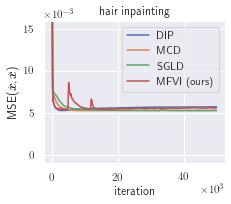

In [15]:
fig, ax0 = plt.subplots(1, 1, figsize=(3.5, 3))

losses_1 = run_1['mse_gt'].flat[0]
losses_2 = run_2['mse_gt'].flat[0]
losses_3 = run_3['mse_gt'].flat[0]
losses_4 = run_4['mse_gt'].flat[0]

ax0.plot(range(len(losses_1['dip']))[::100], losses_1['dip'][::100], label='DIP')
ax0.plot(range(len(losses_3['mcd']))[::100],  losses_2['mfvi'][::100], label='MCD')
ax0.plot(range(len(losses_4['sgld']))[::100], losses_3['mcd'][::100], label='SGLD')
ax0.plot(range(len(losses_2['mfvi']))[::100], losses_4['sgld'][::100], label='MFVI (ours)')
#ax0.fill_between(range(len(loss))[::100], loss[::100]+5*std[::100], loss[::100]-5*std[::100], alpha=0.3)
ax0.set_title(f"hair inpainting")
ax0.set_xlabel('iteration')
ax0.set_ylabel(r'MSE($\hat{\bm{x}}, \tilde{\bm{x}}$)')
ax0.set_ylim(-0.001,0.016)
ax0.grid(True)
ax0.legend()

ax0.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax0.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))

fig.tight_layout()
fig.savefig(f'{out_path}/mse_inp_{img}.pdf', bbox_inches='tight')

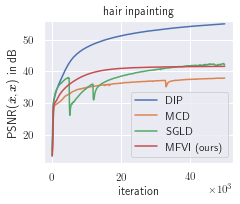

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

ax.plot(range(len(psnrs_1['dip']))[::100], psnrs_1['dip'][::100,2], label='DIP')
ax.plot(range(len(psnrs_3['mcd']))[::100], psnrs_3['mcd'][::100,2], label='MCD')
ax.plot(range(len(psnrs_4['sgld']))[::100], psnrs_4['sgld'][::100,2], label='SGLD')
ax.plot(range(len(psnrs_2['mfvi']))[::100], psnrs_2['mfvi'][::100,2], label='MFVI (ours)')
ax.set_title(f"hair inpainting")
ax.set_xlabel('iteration')
ax.set_ylabel(r'PSNR($\hat{\bm{x}}, \bm{x}$) in dB')
ax.set_ylim([11, 56])
ax.legend()
    
ax.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))

fig.tight_layout()
fig.savefig(f"{out_path}/psnr_inp_{img}.pdf", bbox_inches='tight')

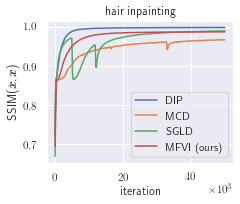

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

ax.plot(range(len(ssims_1["dip"]))[::100], ssims_1["dip"][::100,2], label="DIP")
ax.plot(range(len(ssims_3["mcd"]))[::100], ssims_3["mcd"][::100,2], label="MCD")
ax.plot(range(len(ssims_4["sgld"]))[::100], ssims_4["sgld"][::100,2], label="SGLD")
ax.plot(range(len(ssims_2["mfvi"]))[::100], ssims_2["mfvi"][::100,2], label="MFVI (ours)")
ax.set_title("hair inpainting")
ax.set_xlabel('iteration')
ax.set_ylabel(r'SSIM($\hat{\bm{x}}, \bm{x}$)')
ax.legend()

ax.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))

fig.tight_layout()
fig.savefig(f"{out_path}/ssim_inp_{img}.pdf", bbox_inches='tight')

# Reconstructed images

In [20]:
## after convergence

recons_1 = run_1['recons'].flat[0]['dip']
recons_2 = run_2['recons'].flat[0]['mfvi']
recons_3 = run_3['recons'].flat[0]['mcd']
recons_4 = run_4['recons'].flat[0]['sgld']

io.imsave(f'{out_path}/recon_inp_{img}_dip.png', img_as_ubyte(recons_1[-1][0]))
io.imsave(f'{out_path}/recon_inp_{img}_mfvi.png', img_as_ubyte(recons_2[-1][0]))
io.imsave(f'{out_path}/recon_inp_{img}_mcd.png', img_as_ubyte(recons_3[-1][0]))
io.imsave(f'{out_path}/recon_inp_{img}_sgld.png', img_as_ubyte(recons_4[-1][0]))

# UCE

In [21]:
img_inpainting = run_1['img_inpainting']
img_mask = run_1['img_mask']

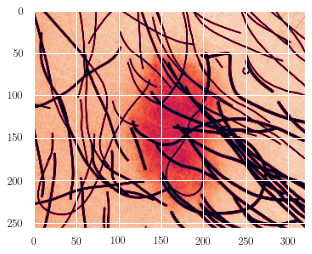

In [137]:
plt.figure()
plt.imshow(img_inpainting[0]*img_mask[0])

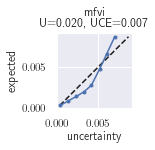

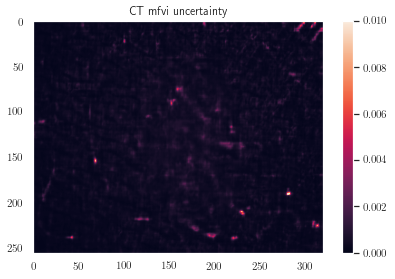

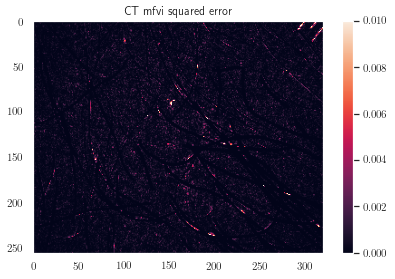

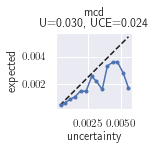

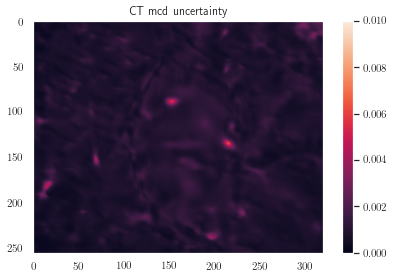

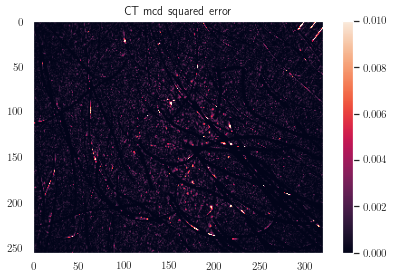

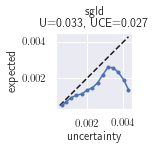

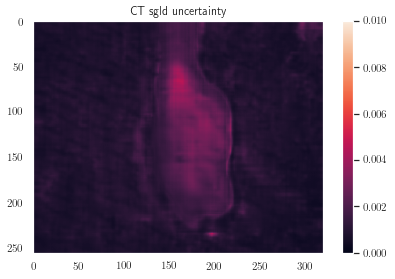

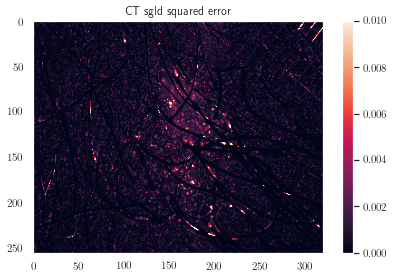

In [144]:
for i, method in enumerate(['mfvi', 'mcd', 'sgld']):
    exec(f'recon = recons_{i+2}')
    exec(f'run = run_{i+2}')
    uncert_1 = run['uncerts'].flat[0][method][-1]
    uncert_ale_1 = run['uncerts_ale'].flat[0][method][-1]

    errs = torch.tensor(img_inpainting)-torch.tensor(recon[-1][0])*img_mask

    uncerts_epi = torch.tensor(uncert_1)
    uncerts_ale = torch.tensor(uncert_ale_1)

    imgs_mc = recon[-25:]
    errvar = ((imgs_mc-img_inpainting[None,].repeat(25,axis=0))**2).mean(axis=(0,))*img_mask
    errs = torch.tensor(errvar).unsqueeze(0).sqrt()[0]
    
    uncerts = (uncerts_epi + uncerts_ale)
    uce, _, _, _ = uceloss(errs**2, uncerts, n_bins=15)
    _, err, uncert, _ = uceloss(errs**2, uncerts, n_bins=15, outlier=1e-4)

    fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.25))
    max_val = np.max([err.max(), uncert.max()])
    min_val = np.min([err.min(), uncert.min()])
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.plot(uncert, err, marker='.')
    ax.set_ylabel(r'expected')
    ax.set_xlabel(r'uncertainty')
    ax.set_aspect(1)
    fig.tight_layout()

    ax.set_title(f'{method}\nU={uncerts.mean().sqrt().item():.3f}, UCE={uce.item()*100:.3f}')
    fig.tight_layout()
    fig.savefig(f'{out_path}/calib_ct_{method}_1.pdf', bbox_inches='tight')
    
    ## save uncert map
    plt.figure()
    plt.imshow(uncerts[0].numpy(), vmin=0, vmax=0.01)
    plt.grid(False)
    plt.colorbar()
    plt.title(f'CT {method} uncertainty')
    plt.tight_layout()
    plt.savefig(f'{out_path}/uncert_map_ct_{method}.pdf', bbox_inches='tight')
    
    ## save error map
    plt.figure()
    plt.imshow(errs.numpy()[0]**2, vmin=0, vmax=0.01)
    plt.grid(False)
    plt.colorbar()
    plt.title(f'CT {method} squared error')
    plt.tight_layout()
    plt.savefig(f'{out_path}/error_map_inp_{img}_{method}.pdf', bbox_inches='tight')